In [1]:
import keras
from keras import backend as K
from keras.utils.generic_utils import CustomObjectScope
from keras.models import load_model
#from keras.applications import mobilenet
from keras.applications import inception_v3
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications.mobilenet import preprocess_input
from PIL import Image
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

def prepare_image(image, target=(224,224)):
    # if the image mode is not RGB, convert it
    if image.mode != "RGB":
        image = image.convert("RGB")

    # resize the input image and preprocess it
    image = image.resize(target)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    # return the processed image
    return image

def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    x=np.copy(x)
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def eval_loss_and_grads(x,clz, loss_func):
    outs = loss_func([x,clz])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

def gradient_descent(x, iterations, step, clz=None, max_loss=None, loss_func=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x, clz, loss_func)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x -= step * grad_values 
    return x

Using TensorFlow backend.


In [0]:
K.set_learning_phase(0)

In [3]:
#model = load_model('model.h5')
model = inception_v3.InceptionV3(weights='imagenet',include_top=True)

96116736/96112376 [==============================] - 6s 0us/step


In [5]:
orig_img = Image.open('trixi.png')
orig_img = prepare_image(orig_img)
print (orig_img.shape)

(1, 224, 224, 3)


40960/35363 [==================================] - 0s 2us/step


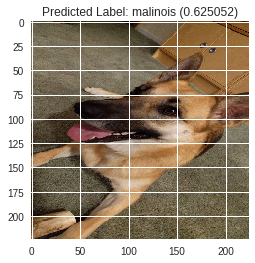

In [6]:
#top_predicted_label = mobilenet.decode_predictions(model.predict(orig_img), top=1)[0][0]
top_predicted_label = inception_v3.decode_predictions(model.predict(orig_img), top=1)[0][0]
plt.title('Predicted Label: %s (%f)' % (top_predicted_label[1], top_predicted_label[2]))
plt.imshow(deprocess_image(orig_img))

In [7]:
tree_frog = np.zeros_like(model.predict(orig_img))
tree_frog[0,31] = 1.
#mobilenet.decode_predictions(tree_frog)
inception_v3.decode_predictions(tree_frog)
# for i in range(100):
#   print(i)
#   tree_frog[0,i] = 1.
#   print(mobilenet.decode_predictions(tree_frog))
#   tree_frog[0,i] = 0.

[[('n01644373', 'tree_frog', 1.0),
  ('n15075141', 'toilet_tissue', 0.0),
  ('n02319095', 'sea_urchin', 0.0),
  ('n02395406', 'hog', 0.0),
  ('n02391049', 'zebra', 0.0)]]

In [8]:
from keras import losses

input_class = K.zeros(shape=(1,1000)) # Variable fake class

# dreaming loss, choose a few layers at random and sum their L2 norms
dream_loss = K.variable(0.)
np.random.seed(1)
np.random.choice(model.layers[:-1], size = 5)
for x in np.random.choice(model.layers[:-1], size = 4):
    x_var = x.output
    dream_loss += np.random.uniform(0,2) * K.sum(K.square(x_var)) / K.prod(K.cast(K.shape(x_var), 'float32'))


# adversarial loss
adversarial_loss = losses.categorical_crossentropy(input_class, model.output)

# final loss
adversarial_dream_loss = adversarial_loss-dream_loss

In [0]:
# Compute the gradients of the dream wrt the loss.
dream = model.input # This is the input image

grads = K.gradients(adversarial_dream_loss, dream)[0] # the signs will acheive the desired effect
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon()) # Normalize for numerical stability
outputs = [adversarial_dream_loss, grads]

# Function to use during dreaming
fetch_loss_and_grads = K.function([dream, input_class], outputs)

In [10]:
# Shamelessly taken from the Keras' example
step = 0.01  # Gradient ascent step size
num_octave = 5  # Number of scales at which to run gradient ascent
octave_scale = 1.2  # Size ratio between scales
iterations = 15  # Number of ascent steps per scale
max_loss = 100.

img = np.copy(orig_img)

if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    print(img.shape)
    img = gradient_descent(img,iterations=iterations,step=step,clz=tree_frog,max_loss=max_loss,loss_func = fetch_loss_and_grads)
    print(img.shape)
    # Upscale
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    print(upscaled_shrunk_original_img.shape)
    same_size_original = resize_img(original_img, shape)
    print(same_size_original.shape)
    # Add back in detail from original image
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    
    shrunk_original_img = resize_img(original_img, shape)

Processing image shape (108, 108)
(1, 108, 108, 3)
..Loss value at 0 : [13.611557]
..Loss value at 1 : [12.421201]
..Loss value at 2 : [11.279989]
..Loss value at 3 : [10.350422]
..Loss value at 4 : [9.3412]
..Loss value at 5 : [8.676224]
..Loss value at 6 : [7.715891]
..Loss value at 7 : [7.1986628]
..Loss value at 8 : [6.3206434]
..Loss value at 9 : [5.828367]
..Loss value at 10 : [5.2789536]
..Loss value at 11 : [4.8276997]
..Loss value at 12 : [4.0676975]
..Loss value at 13 : [3.420515]
..Loss value at 14 : [3.0294085]
(1, 108, 108, 3)
(1, 108, 108, 3)
(1, 108, 108, 3)
Processing image shape (129, 129)
(1, 129, 129, 3)
..Loss value at 0 : [11.980144]
..Loss value at 1 : [9.910698]
..Loss value at 2 : [8.533269]
..Loss value at 3 : [7.771429]
..Loss value at 4 : [6.9641933]
..Loss value at 5 : [5.942026]
..Loss value at 6 : [5.5741434]
..Loss value at 7 : [4.7636023]
..Loss value at 8 : [4.0109634]
..Loss value at 9 : [3.417305]
..Loss value at 10 : [2.5855627]
..Loss value at 11 : 

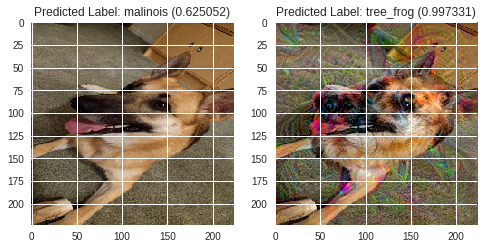

In [11]:
f, axs= plt.subplots(1,2, figsize=(8,10))

top_predicted_label = inception_v3.decode_predictions(model.predict(orig_img), top=1)[0][0]
axs[0].set_title('Predicted Label: %s (%f)' % (top_predicted_label[1], top_predicted_label[2]))
axs[0].imshow(deprocess_image(orig_img))

top_predicted_label = inception_v3.decode_predictions(model.predict(img), top=1)[0][0]
axs[1].set_title('Predicted Label: %s (%f)' % (top_predicted_label[1], top_predicted_label[2]))
axs[1].imshow(deprocess_image(img))

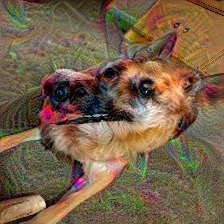

In [12]:
#array_to_img(np.squeeze(img,axis=0))
img=deprocess_image(img)
array_to_img(img)